In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from game import MiningInSpaceGame
from agents import RandomAgent, MeanTrackingAgent, LinearUCBAgent, LinearThompsonAgent, GPUCBAgent, GPThompsonAgent
from simulation import run_batch_simulation

In [2]:
agents_to_test = {
    # "Random": RandomAgent,
    # "MeanTracker": MeanTrackingAgent,
    "Linear-UCB-No-Pseudo (regularization = 0.1)": lambda: LinearUCBAgent(pseudo_observations=False, regularization=1),
    "Linear-UCB-No-Pseudo (regularization = 1)": lambda: LinearUCBAgent(pseudo_observations=False, regularization=1),
    "Linear-UCB-No-Pseudo (regularization = 10)": lambda: LinearUCBAgent(pseudo_observations=False, regularization=10),
    "Linear-UCB-No-Pseudo (regularization = 100)": lambda: LinearUCBAgent(pseudo_observations=False, regularization=100),
    "Linear-UCB-No-Pseudo (regularization = 1000)": lambda: LinearUCBAgent(pseudo_observations=False, regularization=1000),
    # "Linear-Thompson-No-Pseudo (regularization = 100)": lambda: LinearThompsonAgent(pseudo_observations=False, regularization=100),
    # "Gaussian-UCB": GPUCBAgent,
    # "Gaussian-Thompson": GPThompsonAgent
}

# Run simulation

In [3]:
df_results = run_batch_simulation(agents_to_test, MiningInSpaceGame, n_simulations=50, n_trials=150)

Simulating Agent: Linear-UCB-No-Pseudo (regularization = 0.1) (50 runs)...
Simulating Agent: Linear-UCB-No-Pseudo (regularization = 1) (50 runs)...
Simulating Agent: Linear-UCB-No-Pseudo (regularization = 10) (50 runs)...
Simulating Agent: Linear-UCB-No-Pseudo (regularization = 100) (50 runs)...
Simulating Agent: Linear-UCB-No-Pseudo (regularization = 1000) (50 runs)...


In [ ]:
df_results

In [ ]:
# add timestamp day month year hour minute
time_stamp = pd.Timestamp.now().strftime("%d-%m-%Y-%H-%M")
df_results.to_csv(f"simulations/simulation_results-{time_stamp}.csv", index=False)

In [ ]:
df_results.to_clipboard(sep=";")

# Simulation Analysis

In [ ]:
df_results = pd.read_csv("simulations/simulation_results_15_12_1.csv")

In [ ]:
learning_curves = df_results.groupby(['agent_name', 'trial'])['reward_received'].mean().reset_index()

# ---------------------------------------------------------
# Graph 1: Combined Learning Curves (Averages Only)
# ---------------------------------------------------------
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=learning_curves, 
    x='trial', 
    y='reward_received', 
    hue='agent_name',
    linewidth=2
)

plt.axhline(y=50, color='gray', linestyle='--', label='Chance Level (50)')
plt.title('Agent Learning Curves: Average Score per Trial', fontsize=16)
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(title='Agent', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('learning_curves.pdf')
plt.show()

In [ ]:
def plot_single_simulation_uncertainty(data, simulation_id, agent_name):
    """
    Plots uncertainty for a single run, labeling the legend 
    with the actual logic (A-D) behind each physical button.
    """
    subset = data[(data['simulation_id'] == simulation_id) & 
                  (data['agent_name'] == agent_name)].copy()
    
    if subset.empty:
        print(f"No data for Sim {simulation_id}")
        return

    # Grab the mapping from the first row of this simulation
    # (The mapping is constant throughout one game)
    first_row = subset.iloc[0]
    
    plt.figure(figsize=(10, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] 
    
    for i in range(4):
        # Get the logic label (A, B, C, D) for this arm index
        logic_label = first_row[f'mapping_arm_{i}']
        
        plt.plot(subset['trial'], subset[f'agent_sigma_{i}'], 
                 label=f'Arm {i} (Logic {logic_label})', 
                 color=colors[i], linewidth=2)
    
    plt.title(f"Uncertainty per Arm - Sim {simulation_id} ({agent_name})")
    plt.xlabel("Trial")
    plt.ylabel("Uncertainty ($\sigma$)")
    plt.legend(title="Physical Arms")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_aggregated_uncertainty(data, agent_name):
    """
    Plots the average uncertainty for each STRATEGY (A, B, C, D) 
    across all simulations.
    """
    subset = data[data['agent_name'] == agent_name].copy()
    
    if subset.empty:
        print(f"No data for {agent_name}")
        return
        
    # --- CRITICAL STEP: UN-SHUFFLE THE DATA ---
    # We cannot just melt sigma_0...sigma_3 because Arm 0 changes meaning.
    # We must construct a long-form dataframe pairing Sigma with its Logic Label.
    
    pieces = []
    for i in range(4):
        # Create a temporary dataframe for Arm 'i'
        temp = subset[['trial', 'simulation_id']].copy()
        temp['Uncertainty'] = subset[f'agent_sigma_{i}']
        temp['Strategy'] = subset[f'mapping_arm_{i}'] # This column has 'A','B','C', or 'D'
        pieces.append(temp)
    
    # Stack them all together
    long_data = pd.concat(pieces, ignore_index=True)
    
    # Now we plot based on Strategy (A-D), not Physical Arm (0-3)
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(
        data=long_data,
        x='trial',
        y='Uncertainty',
        hue='Strategy',
        hue_order=['A', 'B', 'C', 'D'], # Force consistent order
        errorbar=('ci', 95),
        palette='tab10'
    )
    
    plt.title(f"Average Uncertainty by Strategy - {agent_name}")
    plt.xlabel("Trial")
    plt.ylabel("Perceived Uncertainty ($\sigma$)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(title="Logic Strategy")
    plt.tight_layout()
    plt.show()

In [ ]:
random_run = random.choice(df_results['simulation_id'].unique())
plot_single_simulation_uncertainty(df_results, simulation_id=random_run, agent_name="Linear-Thompson-No-Pseudo")

In [ ]:
plot_aggregated_uncertainty(df_results, agent_name="Linear-UCB-No-Pseudo")

In [ ]:
def plot_single_sim_width(data, simulation_id, agent_name):
    """
    Plots the interval width for a single run, labeling lines 
    with the actual logic (A-D) behind each physical button.
    """
    subset = data[(data['simulation_id'] == simulation_id) & 
                  (data['agent_name'] == agent_name)].copy()
    
    if subset.empty:
        print("No data found.")
        return

    # Get the mapping from the first row of this simulation
    first_row = subset.iloc[0]

    plt.figure(figsize=(10, 6))
    
    # Standard colors for physical arms 0-3
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i in range(4):
        # 1. Calculate Width using the correct column names
        # Note: Previous simulation code saved these as 'agent_upper_{i}', not 'agent_belief_...'
        width = subset[f'agent_upper_{i}'] - subset[f'agent_lower_{i}']
        
        # 2. Get the Logic Label (A, B, C, D)
        logic_label = first_row[f'mapping_arm_{i}']
        
        plt.plot(subset['trial'], width, 
                 label=f'Arm {i} (Logic {logic_label})', 
                 color=colors[i], linewidth=2)
        
    plt.title(f"Interval Width Evolution - Sim {simulation_id} ({agent_name})")
    plt.xlabel("Trial")
    plt.ylabel("Width of Interval (Upper - Lower)")
    plt.legend(title="Physical Arms")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_avg_width(data, agent_name):
    """
    Plots the average interval width grouped by STRATEGY (A, B, C, D)
    across all simulations.
    """
    subset = data[data['agent_name'] == agent_name].copy()
    
    if subset.empty:
        print(f"No data for {agent_name}")
        return
    
    # --- CRITICAL: Un-shuffle physical arms into Logic Strategies ---
    pieces = []
    for i in range(4):
        # Select relevant columns for physical arm 'i'
        temp = subset[['trial', 'simulation_id']].copy()
        
        # Calculate width
        temp['width'] = subset[f'agent_upper_{i}'] - subset[f'agent_lower_{i}']
        
        # Identify which strategy this arm represented in this specific row
        temp['Strategy'] = subset[f'mapping_arm_{i}'] 
        
        pieces.append(temp)
    
    # Combine into one long dataframe
    long_data = pd.concat(pieces, ignore_index=True)
    
    plt.figure(figsize=(10, 6))
    
    # Plot using Strategy as the hue (Logic A vs Logic D)
    sns.lineplot(
        data=long_data,
        x='trial',
        y='width',
        hue='Strategy',
        hue_order=['A', 'B', 'C', 'D'], # Consistent legend order
        errorbar=('ci', 95),
        palette='tab10'
    )
    
    plt.title(f"Average Interval Width by Strategy - {agent_name}")
    plt.xlabel("Trial")
    plt.ylabel("Average Width (Upper - Lower)")
    plt.legend(title="Logic Strategy")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
random_run = random.choice(df_results['simulation_id'].unique())
plot_single_sim_width(df_results, simulation_id=random_run, agent_name="Linear-Thompson-No-Pseudo")

In [ ]:
plot_avg_width(df_results, agent_name="Linear-Thompson-No-Pseudo")

In [ ]:
def plot_single_sim_cumulative_choices(data, simulation_id, agent_name):
    """
    Plots the cumulative count of selections for each Planet strategy (A, B, C, D).
    """
    # 1. Filter and Reset Index (Crucial for alignment)
    subset = data[(data['simulation_id'] == simulation_id) & 
                  (data['agent_name'] == agent_name)].copy().reset_index(drop=True)
    
    if subset.empty:
        print(f"No data for Sim {simulation_id}")
        return
    
    plt.figure(figsize=(10, 6))
    
    # 2. One-hot encode the 'choice_Planet_label' (A, B, C, D)
    # Prefix 'Planet' makes it clear this is NOT the physical arm index
    dummies = pd.get_dummies(subset['choice_planet_label'], prefix='Planet')
    
    # 3. Ensure all Planet Types (A-D) are present
    possible_labels = ['A', 'B', 'C', 'D']
    for label in possible_labels:
        col_name = f'Planet_{label}'
        if col_name not in dummies.columns:
            dummies[col_name] = 0
            
    # 4. Sort columns so Legend is always A, B, C, D
    dummies = dummies.reindex(sorted(dummies.columns), axis=1)
    
    # 5. Calculate Cumulative Sum
    cumulative = dummies.cumsum()
    
    # 6. Plot
    # We use subset['trial'] as x-axis
    for col in cumulative.columns:
        clean_label = col.replace('_', ' ') # "Planet_A" -> "Planet A"
        plt.plot(subset['trial'], cumulative[col], label=clean_label, linewidth=2)
        
    plt.title(f"Cumulative Strategy Selection - Sim {simulation_id} ({agent_name})")
    plt.xlabel("Trial")
    plt.ylabel("Total Times Chosen")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_avg_selection_prob(data, agent_name):
    """
    Plots the probability of choosing each Planet strategy over time, 
    averaged across all simulations.
    """
    # 1. Filter and Reset Index
    subset = data[data['agent_name'] == agent_name].copy().reset_index(drop=True)
    
    if subset.empty:
        print(f"No data for {agent_name}")
        return
    
    # 2. One-hot encode choices
    dummies = pd.get_dummies(subset['choice_planet_label'])
    
    # Safer renaming: Add prefix directly
    dummies = dummies.add_prefix('Planet ') # Becomes "Planet A", "Planet B"
    
    # 3. Ensure all Planets (A-D) exist
    possible_labels = ['A', 'B', 'C', 'D']
    target_columns = [f"Planet {x}" for x in possible_labels]
    
    for col in target_columns:
        if col not in dummies.columns:
            dummies[col] = 0
            
    # 4. Combine with trial info
    # Because we reset_index() earlier, this concat is safe!
    with_dummies = pd.concat([subset[['trial']], dummies], axis=1)
    
    # 5. Melt for Seaborn
    melted = with_dummies.melt(
        id_vars=['trial'], 
        value_vars=target_columns,
        var_name='Strategy', 
        value_name='Selection' # Value is 0 or 1
    )
    
    plt.figure(figsize=(10, 6))
    
    sns.lineplot(
        data=melted,
        x='trial',
        y='Selection',
        hue='Strategy',
        hue_order=target_columns, # Force legend order A -> D
        errorbar=None, 
        linewidth=2.5
    )
    
    plt.title(f"Strategy Selection Probability (Average) - {agent_name}")
    plt.xlabel("Trial")
    plt.ylabel("Probability of Selection")
    plt.ylim(-0.05, 1.05)
    plt.legend(title="Strategy")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
random_run = random.choice(df_results['simulation_id'].unique())
plot_single_sim_cumulative_choices(df_results, simulation_id=random_run, agent_name="Linear-Thompson-No-Pseudo")

In [ ]:
plot_avg_selection_prob(df_results, agent_name="Linear-Thompson-No-Pseudo")

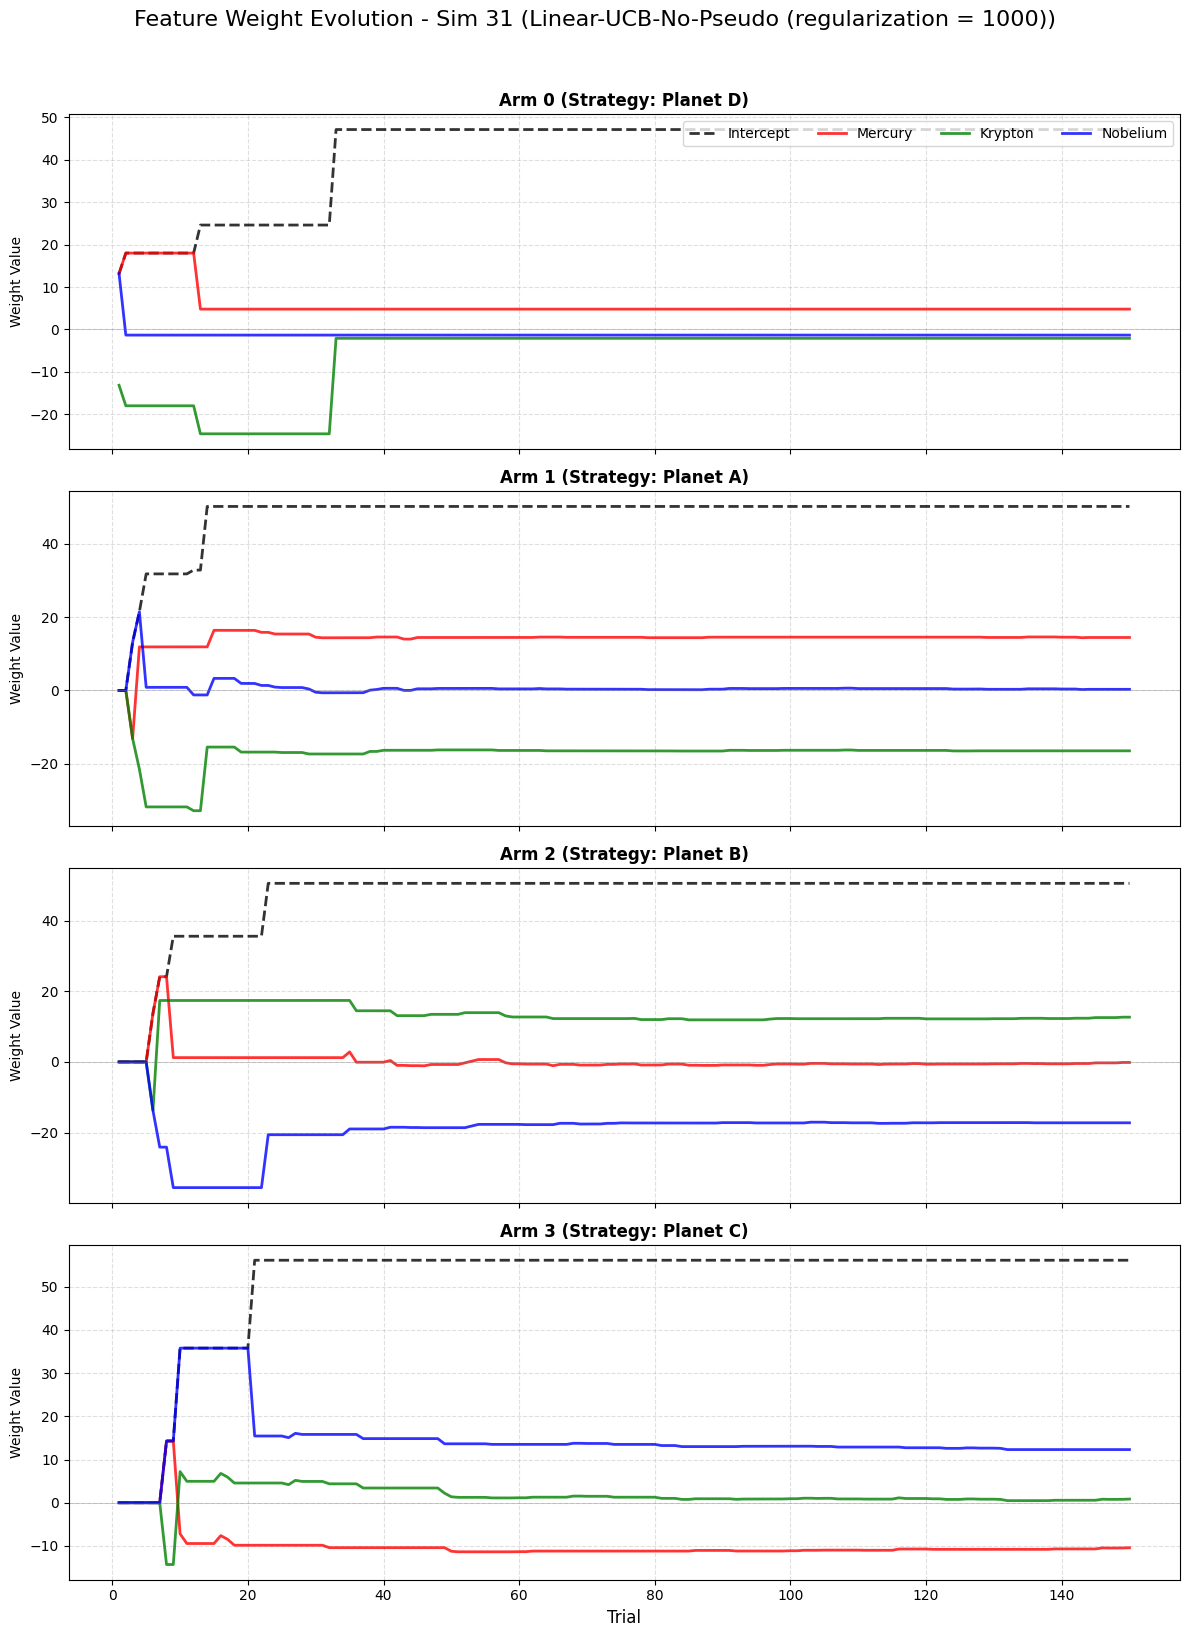

In [5]:
def plot_weight_evolution(data, simulation_id, agent_name):
    """
    Plots the evolution of feature weights (Intercept, Mercury, Krypton, Nobelium)
    for all 4 arms, stacked vertically.
    """
    # 1. Filter Data
    subset = data[(data['simulation_id'] == simulation_id) & 
                  (data['agent_name'] == agent_name)].copy().reset_index(drop=True)
    
    if subset.empty:
        print(f"No data for Sim {simulation_id} - {agent_name}")
        return

    # 2. Setup Figure (4 rows, 1 column)
    n_arms = 4
    fig, axes = plt.subplots(n_arms, 1, figsize=(12, 16), sharex=True)
    
    # Define styles for consistent plotting
    # Format: feature_key: (Display Name, Color, LineStyle)
    feature_styles = {
        'intercept': ('Intercept', 'black', '--'),
        'mercury':   ('Mercury',   'red',   '-'),
        'krypton':   ('Krypton',   'green', '-'),
        'nobelium':  ('Nobelium',  'blue',  '-')
    }

    # 3. Loop through each Arm
    for arm_idx in range(n_arms):
        ax = axes[arm_idx]
        
        # Retrieve the Planet Label (A, B, C, D) mapped to this arm in this specific sim
        planet_label = subset.iloc[0][f'mapping_arm_{arm_idx}']
        
        # Plot each feature weight
        for key, (label, color, style) in feature_styles.items():
            col_name = f'w_{key}_arm_{arm_idx}'
            
            if col_name in subset.columns:
                ax.plot(subset['trial'], subset[col_name], 
                        label=label, color=color, linestyle=style, linewidth=2, alpha=0.8)
        
        # Aesthetics
        ax.set_title(f"Arm {arm_idx} (Strategy: Planet {planet_label})", fontsize=12, fontweight='bold')
        ax.set_ylabel("Weight Value")
        ax.grid(True, which='both', linestyle='--', alpha=0.4)
        ax.axhline(0, color='grey', linewidth=0.5, alpha=0.5) # Zero reference line
        
        # Add legend only to the first plot to avoid clutter
        if arm_idx == 0:
            ax.legend(loc='upper right', ncol=4, frameon=True)

    plt.xlabel("Trial", fontsize=12)
    plt.suptitle(f"Feature Weight Evolution - Sim {simulation_id} ({agent_name})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
random_run = np.random.choice(df_results['simulation_id'].unique())
plot_weight_evolution(df_results, simulation_id=random_run, agent_name="Linear-UCB-No-Pseudo (regularization = 1000)")